In [122]:
import os
import sys
src_path = sys.path[0].replace("paper_working", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("paper_working", "output")

import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

rc_={
    "figure.dpi":600,
    "font.size":8,
    "axes.facecolor":"white",
    "savefig.facecolor":"white",
    "text.usetex":False,
    "legend.frameon":False
}
plt.rcParams.update(rc_)
legend_fs=10
label_fs=14
ticklabel_fs=10
from utils.plot_utils import *
customize_plt() # customize plt configs, see plot_utils

In [123]:
keys = ["load_pv", "load_bld", "bat_p", "ev_p", "p_grid", "latest_p_grid_max"]
colors = {"load_pv":"rebeccapurple","load_bld":"chocolate","p_grid":"royalblue",
          "bat_p":"darkgreen","ev_p":"darkorange","cost":"firebrick",
        "gg":"seagreen", "gge":"seagreen", "pp":"royalblue", "nn":"plum",
          "msc":"firebrick", "tou":"sandybrown", "latest_p_grid_max":"orangered"}
names = {"load_pv":"PV","load_bld":"Building","p_grid":"Grid",
          "bat_p":"Battery","ev_p":"EV","cost":"Cost",
        "gg":"MPC-GG", "gge":"MPC-GGE", "pp":"MPC-PP", "nn":"MPC-NN",
          "msc":"MSC", "tou":"TOU", "latest_p_grid_max":"Grid-max"}

In [124]:
log_fn = r"L:\Coding_project\Energy_grid_new\output\experiments\thesis_daily_profile\6h-bat-Oct-GT&Heuristic.xlsx"
log_df = pd.read_excel(log_fn, index_col=0)
exp_name = r"6h-bat-Oct-GT&Heuristic"
exp_folder=r"L:\Coding_project\Energy_grid_new_exp_local\thesis_daily_profile"
log_df

,status,bld,pv,ev,method,strategy,B_kWh,pred_model,deg_model_opt,deg_model,...,grid_export,import_cost,export_revenue,grid_max,bat_e_terminal,bat_e_terminal_revenue,load_bld_error_max_neg,load_bld_error_max_pos,load_pv_error_max_neg,load_pv_error_max_pos
id,,,,,,,,,,,,,,,,,,,,,
1,D,Sum,Sum,ALL,MPC,optimal,438,GT,unconscious,unconscious,...,12.619448,192.421300,2.199477,131.982173,54.979737,1.556541,0.000000,0.000000,0.000000,0.000000
2,D,Sum,Sum,ALL,MPC,optimal,438,Simple,unconscious,unconscious,...,69.059310,201.571552,8.692411,242.436935,0.000000,0.000000,-8.039658,8.156605,-69.897895,78.564239
3,D,Sum,Sum,ALL,MPC,optimal,438,GT,unconscious,unconscious,...,12.619448,183.623025,2.199477,168.887400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,D,Sum,Sum,ALL,MPC,optimal,438,Simple,unconscious,unconscious,...,72.212371,200.901361,9.020807,248.200821,0.000000,0.000000,-8.039658,8.156605,-69.897895,78.564239


In [125]:
def get_trial_res(idx_mpc, idx_gt):
    mpc_fn = log_df.loc[idx_mpc, "save_fn"]
    gt_fn  = log_df.loc[idx_gt, "save_fn"]
    mpc_df = pd.read_excel(os.path.join(exp_folder, exp_name, mpc_fn), sheet_name=None, index_col=0)
    gt_df = pd.read_excel(os.path.join(exp_folder, exp_name, gt_fn), sheet_name="op_log", index_col=0)
    return mpc_df, gt_df

def draw_load_curve(mpc_df, gt_df, key, t0=datetime(2019,10,1,0,0), pred_t=0, gif=False, ax=None):

    ax = plt.gca() if ax is None else ax

    K, delta, exe_K = 96, 0.25, 4

    ts = pd.date_range(t0, t0+timedelta(hours=24), freq=f"{delta}H", inclusive="left")
    ts_exe = pd.date_range(t0, t0+timedelta(hours=24), freq=f"{delta*exe_K}H", inclusive="left")

    y_gt = gt_df.loc[ts, key].values
    if key in ["load_bld", "load_pv"]:
        y_mpc = mpc_df[f"pred_{key}"].loc[ts_exe, range(exe_K)].values.reshape(-1,)
    else:
        y_mpc = mpc_df["op_log"].loc[ts, key].values

    if key != 'latest_p_grid_max':
        y_pred = mpc_df[f"pred_{key}"].loc[
        t0+timedelta(hours=pred_t), range(K - int(pred_t/delta))].values

    # if key == "load_pv":
    #     y_gt *= -1
    #     y_mpc *= -1
    #     y_pred *= -1

    x = np.arange(0, K*delta, delta)
    x_pred = np.arange(pred_t, K*delta, delta)

    c = colors[key]

    
    if gif:
        exe_steps = int(pred_t/delta)+1

        ax.fill_between(x[:exe_steps], y_gt[:exe_steps], y_mpc[:exe_steps], color=c, alpha=0.2, edgecolor="none", zorder=200)
        if key != 'latest_p_grid_max':
            ax.fill_between(x_pred, y_gt[exe_steps-1:], y_pred, color=c, alpha=0.6, edgecolor="none", zorder=200)
        ax.plot(x[:exe_steps], y_mpc[:exe_steps], color=c)
        if key != 'latest_p_grid_max':
            ax.plot(x_pred, y_pred, color=c, alpha=0.8, lw=1.5, ls="dashed", zorder=-100)
    else:
        ax.fill_between(x, y_gt, y_mpc, color=colors[key], edgecolor="none", alpha=0.3, zorder=-200)
        ax.plot(x, y_mpc, c=colors[key])
        if key != 'latest_p_grid_max':
            ax.plot(x_pred, y_pred, color=colors[key], lw=1, ls="dashed", zorder=-100)
            
def text_with_ratio(text, x_ratio, y_ratio, ax, **kw):
    x_lo, x_hi = ax.get_xlim()
    y_lo, y_hi = ax.get_ylim()
    x = x_lo + x_ratio * (x_hi - x_lo)
    y = y_lo + y_ratio * (y_hi - y_lo)
    ax.text(x, y, text, **kw)
    
    
gif = False
pred_t = 0

def draw_load_breakdown(mpc_df, gt_df, mpc_df2, gt_df2, figsize, label_loc=[0.05,0.88],
                        gif=False, pred_t=0, title_l=None,title_r=None, limit_dic=None):
    fig, axs = plt.subplots(ncols=2, nrows=5, figsize=figsize, gridspec_kw={"height_ratios":[1,1,1,1,1]})
    #gs = axs[0,2].get_gridspec()
    # remove the underlying axes
    #for ax in axs[:, -1]:
    #    ax.remove()
    #axbig = fig.add_subplot(gs[:, -1])
    for i in range(2):
        key = keys[i]
        ax=axs[0,i]
        ax.tick_params(axis='both',which='major',labelsize=ticklabel_fs)
        draw_load_curve(mpc_df, gt_df, key, t0=datetime(2019,5,1,0,0), pred_t=pred_t, gif=gif, ax=ax) 
        ax.set_xticks(np.arange(0, 25, 6)) 
        ax.set_xticklabels([])
        ax.set_ylim(limit_dic[key])
        ax.tick_params(direction='in', axis="x")
        
        ax.set_ylim(-5,200)
        if i==1:
            ax.set_yticklabels([])
            ax.tick_params(direction='in', axis="y")
        text_with_ratio(names[key], label_loc[0], label_loc[1], ax, ha="left", va="bottom", fontsize=label_fs*1.2, color=colors[key])
    #    draw_load_curve(mpc_df, gt_df, key, t0=datetime(2019,5,1,0,0), pred_t=pred_t, gif=gif, ax=axs[0,1])  
    
    

    for i in range(4):
        key = keys[i+2]
        ax = axs[i+1, 0]
        draw_load_curve(mpc_df, gt_df, key, t0=datetime(2019,5,1,0,0), pred_t=pred_t, gif=gif, ax=ax)
        ax.set_xticks(np.arange(0, 25, 6))
        ax.set_ylim(limit_dic[key])
        ax.tick_params(axis='both',which='major',labelsize=ticklabel_fs)
        if i!=3:
            ax.set_xticklabels([])
            ax.tick_params(direction='in', axis="x")
        else:
            ax.set_xlabel('Hour of day',loc='left', fontsize=label_fs)
        if key == "latest_p_grid_max":
            ax.set_title(title_l,y=-0.4, fontsize=label_fs, fontweight='bold')
            text_with_ratio("1 May, 2019", 0.05, 0.1, ax, ha="left", va="bottom", fontsize=label_fs, color="dimgrey")
        if key == "ev_p":
            ax.set_ylabel("Power (kW)",fontsize=label_fs)
            
        text_with_ratio(names[key], label_loc[0], label_loc[1], ax, ha="left", va="bottom", fontsize=label_fs*1.2, color=colors[key])
        
    for i in range(4):
        key = keys[i+2]
        ax = axs[i+1, 1]
        
        if i!=3:
            ax.set_xticklabels([])
            ax.tick_params(direction='in', axis="x")
            ax.tick_params(axis='both',which='major',labelsize=ticklabel_fs)
        if key == "latest_p_grid_max":
            ax.set_title(title_r,y=-0.4, fontsize=label_fs, fontweight='bold')
            ax.fill_between([0,0], [0,0], [0,0], color="dimgrey", edgecolor="none", alpha=0.3, label="discr. w/ GT")
            ax.plot([0,0], [0,0], c="dimgrey", label="Operate")
            ax.plot([0,0], [0,0], c="dimgrey", lw=1, ls="dashed", zorder=-100, label="Schedule")
            ax.legend(loc="lower left", fontsize=label_fs, labelcolor="dimgrey", handlelength=2)
            ax.tick_params(axis='both',which='major',labelsize=ticklabel_fs)
            
        draw_load_curve(mpc_df2, gt_df2, key, t0=datetime(2019,5,1,0,0), pred_t=pred_t, gif=gif, ax=ax)
        ax.set_ylim(limit_dic[key])
        ax.set_xticks(np.arange(0, 25, 6))
        ax.set_yticklabels([])
        ax.tick_params(axis='both',which='major',labelsize=ticklabel_fs)
        ax.tick_params(direction='in', axis="y")
        
    
        
    '''       
        if i//2 == 0:
            ax.set_ylim(-5, 205)
        else:
            ax.set_ylim(-255, 255)
            if i%2 == 0:
                ax.set_ylabel("Power (kW)",fontsize=18)
            
        ax.set_xticks(np.arange(0, 25, 6))
        ax.set_xticklabels([])
        ax.tick_params(direction='in', axis="x")
        if i%2 == 1:
            ax.set_yticklabels([])
            ax.tick_params(direction='in', axis="y")
        
        text_with_ratio(names[key], 0.05, 0.88, ax, ha="left", va="bottom", fontsize=18, color=colors[key])
        
    #ax = axbig
    key = "p_grid"
    def plot_right_part(ax,key):
        draw_load_curve(mpc_df, gt_df, key, t0=datetime(2019,5,1,0,0), pred_t=pred_t, gif=gif, ax=ax)
        if key == "p_grid":
            ax.set_xticks(np.arange(0, 25, 6))
            ax.yaxis.set_label_position("left")
            ax.yaxis.tick_left()
            
        ax.set_ylim(-55, 285)
        ax.set_xlim(-0.5, 24.5)
        
        text_with_ratio(names[key], 0.05, 0.88, ax, ha="left", va="bottom", fontsize=18, color=colors[key])
        # legend

        #ax.set_xticklabels([])
        ax.tick_params(direction='out', axis="x")
        if key=='latest_p_grid_max':
            ax.set_yticklabels([])
            ax.tick_params(direction='in', axis="y")
            ax.yaxis.tick_left()
            ax.fill_between([-100,-100], [0,0], [0,0], color="dimgrey", edgecolor="none", alpha=0.3, label="discr. w/ GT")
            ax.plot([-100,-100], [0,0], c="dimgrey", label="Operate")
            ax.plot([-100,-100], [0,0], c="dimgrey", lw=1, ls="dashed", zorder=-100, label="Schedule")
            ax.legend(loc="lower left", fontsize=16, labelcolor="dimgrey", handlelength=2)
            text_with_ratio("1 May, 2019", 0.65, 0.05, ax, ha="left", va="bottom", fontsize=14, color="dimgrey")
        
    axs[2,0].set_xlabel("Hour of day",fontsize=18,loc="left")      
            
    plot_right_part(axs[2,0],'p_grid')
    plot_right_part(axs[2,1],'latest_p_grid_max')'''
    
    
    

    if gif:
        text_with_ratio("{:02}:00".format(pred_t), 0.5, 0.10, ax, ha="left", va="bottom", fontsize=22, color="dimgrey")

    plt.tight_layout()

    return fig

In [126]:
heuristic_dc_df, gt_dc_df = get_trial_res(2,1)
heuristic_0dc_df, gt_0dc_df = get_trial_res(4,3)

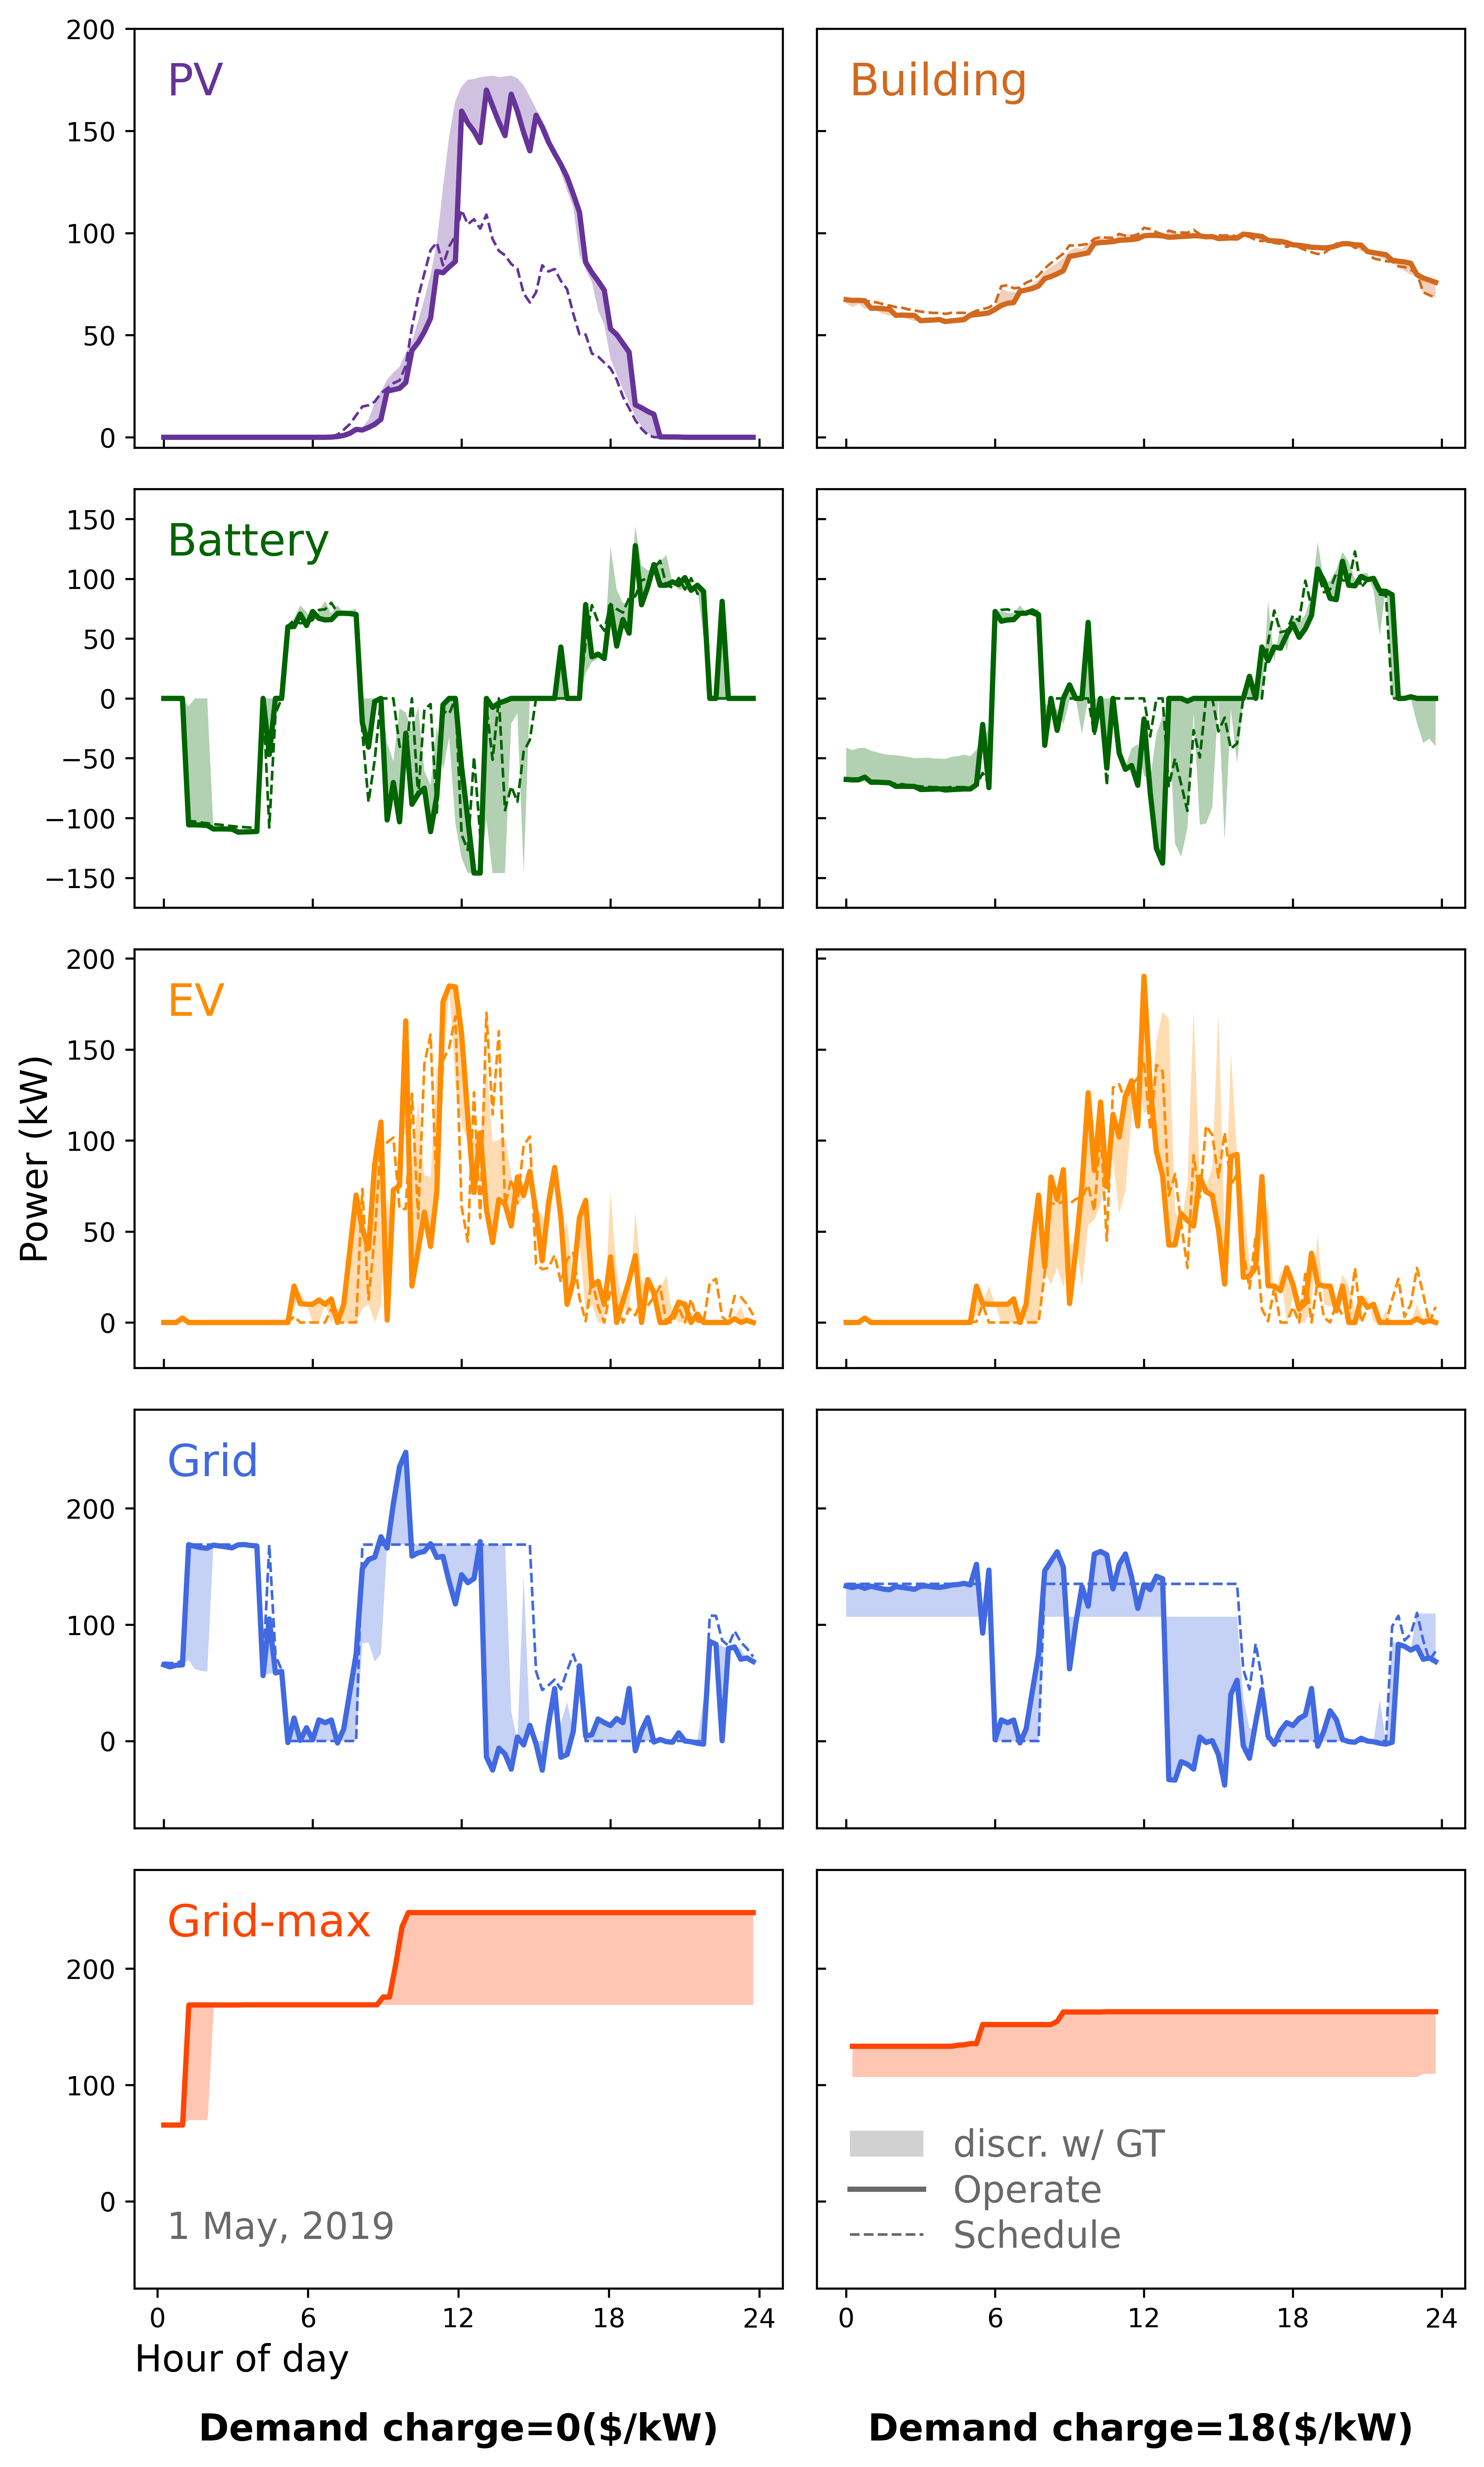

In [127]:
fig1 = draw_load_breakdown(heuristic_0dc_df, gt_0dc_df,heuristic_dc_df, gt_dc_df, 
                           gif=False, pred_t=0, figsize=[8,13],
                           title_l="Demand charge=0($/kW)",
                           title_r="Demand charge=18($/kW)",
                           label_loc=[0.05,0.82],
                           limit_dic={
                               "load_pv":[-25,200], "load_bld":[-25,200], 
                               "bat_p":[-175,175], "ev_p":[-25,205], 
                               "p_grid":[-75,285], "latest_p_grid_max":[-75,285]
                           })
fig1.savefig("fig1-MPC_profile_GT&Heuristic.png", facecolor="w", bbox_inches="tight")